### Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №3 - Дерево решений


**Общая информация**

**Срок сдачи:** 3 мая 2021, 08:30   
**Штраф за опоздание:** -2 балла после 08:30 03 мая, -4 балла после 08:30 10 мая, -6 баллов после 08:30 17 мая, -8 баллов после 08:30 24 мая.

При отправлении ДЗ указывайте фамилию в названии файла Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:
[ML0221, Задание 3] Фамилия Имя. 


Используйте данный Ipython Notebook при оформлении домашнего задания.

##  Реализуем дерево решений (3 балла)

Допишите недостающие части дерева решений. Ваша реализация дерева должна работать по точности не хуже DecisionTreeClassifier из sklearn.
Внимание: если Вас не устраивает предложенная структура хранения дерева, Вы без потери баллов можете сделать свой класс DecisionTreeClassifier, в котором сами полностью воспроизведете алгоритм дерева решений. Обязательно в нем иметь только функции fit, predict

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.datasets import load_wine
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier


In [63]:
from sklearn.base import BaseEstimator
class MyDecisionTreeClassifier(BaseEstimator):
    NON_LEAF_TYPE = 0
    LEAF_TYPE = 1

    def __init__(self, min_samples_split=2, max_depth=5, criterion='gini'):
        """
        criterion -- критерий расщепления. необходимо релизовать три:
        Ошибка классификации, Индекс Джини, Энтропийный критерий
        max_depth -- максимальная глубина дерева
        min_samples_split -- минимальное число объектов в листе, чтобы сделать новый сплит
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.num_class = -1
        # Для последнего задания
        self.feature_importances_ = None
        self.criterion = criterion
        # Структура, которая описывает дерево
        # Представляет словарь, где для  node_id (айдишник узла дерева) храним
        # (тип_узла, айдишник признака сплита, порог сплита) если тип NON_LEAF_TYPE
        # (тип_узла, предсказание класса, вероятность класса) если тип LEAF_TYPE
        # Подразумевается, что у каждого node_id в дереве слева 
        # узел с айди 2 * node_id + 1, а справа 2 * node_id + 2
        self.tree = dict()

    def __div_samples(self, x, y, feature_id, threshold):
        """
        Разделяет объекты на 2 множества
        x -- матрица объектов
        y -- вектор ответов
        feature_id -- айдишник признака, по которому делаем сплит
        threshold -- порог, по которому делаем сплит
        """
        left_mask = x[:, feature_id] > threshold
        right_mask = ~left_mask
        return x[left_mask], x[right_mask], y[left_mask], y[right_mask]

    def __find_threshold(self, x, y):
        """
        Находим оптимальный признак и порог для сплита
        Здесь используемые разные impurity в зависимости от self.criterion
        """
        max_Q = np.zeros(x.shape[1])
        thresholds = np.zeros(x.shape[1])
        Q = 0
        for feature_id in range(x.shape[1]):
            index_sort = np.argsort(x[:, feature_id])
            x_sort = x[:, feature_id][index_sort]
            x_sort = x_sort[~np.isnan(x_sort)]
            y_sort = y[index_sort][:x_sort.size]
            
            
            dif_features = np.asarray(y_sort[:-1] != y_sort[1:]).nonzero()[0]
            if dif_features.size == 0:
                continue
            classes = np.zeros((y_sort.size - 1, self.num_class))
            classes[np.arange(y_sort.size - 1), y_sort[:-1]] = 1
            left_split = np.cumsum(classes, axis = 0)
            right_split = np.bincount(y_sort, minlength = self.num_class) - left_split
            left_samples = np.sum(left_split, axis = 1)
            right_samples = y_sort.size - left_samples

            if self.criterion == 'gini':
                Q = (self.F_gini(left_split + right_split, y_sort.size) - left_samples/y_sort.size
                        * self.F_gini(left_split, left_samples.reshape(-1,1)) - right_samples/y_sort.size
                        * self.F_gini(right_split, right_samples.reshape(-1,1)))
            elif self.criterion == 'entropy':
                Q = (self.F_entropy(left_split + right_split, y_sort.size) - left_samples/y_sort.size
                        * self.F_entropy(left_split, left_samples.reshape(-1,1)) - right_samples/y_sort.size
                        * self.F_entropy(right_split, right_samples.reshape(-1,1)))
            elif self.criterion == 'class':
                Q = (self.F_class(left_split + right_split, y_sort.size) - left_samples/y_sort.size
                        * self.F_class(left_split, left_samples.reshape(-1,1)) - right_samples/y_sort.size
                        * self.F_class(right_split, right_samples.reshape(-1,1)))
            else:
                raise Exception("Wrong Criterion!")
            
            max_Q[feature_id] = np.max(Q)
            thresholds[feature_id] = x_sort[np.argmax(Q)]

        max_Q_index = np.argmax(max_Q)
        optimal_threshold = thresholds[max_Q_index]
        self.feature_importances_[max_Q_index] += np.max(max_Q)
        return max_Q_index, optimal_threshold
                    
    def F_gini(self, div_samples, size):
        return 1 - np.sum(((div_samples / size)**2), axis = 1)   
    
    def F_entropy(self, div_samples, size):
        p = div_samples / size
        p[p == 0] = 1
        return -np.sum(p * np.log(p), axis = 1)
    
    def F_class(self, div_samples, size):
        return 1 - np.max(div_samples/size, axis = 1)
    
    
    def __fit_node(self, x, y, node_id, depth):
        """
        Делаем новый узел в дереве
        Решаем, терминальный он или нет
        Если нет, то строим левый узел  с айди 2 * node_id + 1
        И правый узел с  айди 2 * node_id + 2
        """
        classes, counts = np.unique(y, return_counts=True)
        max_class = classes[np.argmax(counts)]
        p = np.max(counts) / y.size
        if (depth == self.max_depth) or (y.size < self.min_samples_split):
            self.tree[node_id] = (self.__class__.LEAF_TYPE, max_class, p)
        else:
            feature_id, threshold = self.__find_threshold(x, y)
            x_left, x_right, y_left, y_right = self.__div_samples(x, y, feature_id, threshold)
            if (x_left.size == 0) or (x_right.size == 0):
                self.tree[node_id] = (self.__class__.LEAF_TYPE, max_class, p)
            else:
                self.tree[node_id] = (self.__class__.NON_LEAF_TYPE, feature_id, threshold)
                self.__fit_node(x_left, y_left, 2 * node_id + 1, depth + 1)
                self.__fit_node(x_right, y_right, 2 * node_id + 2, depth + 1)
                
    def fit(self, x, y):
        """
        Рекурсивно строим дерево решений
        Начинаем с корня node_id 0
        """
        self.feature_importances_ = dict.fromkeys((i for i in range(x.shape[1])), 0)
        self.num_class = np.unique(y).size
        self.__fit_node(x, y, 0, 0) 

    def __predict_class(self, x, node_id):
        """
        Рекурсивно обходим дерево по всем узлам,
        пока не дойдем до терминального
        """
        node = self.tree[node_id]
        if node[0] == self.__class__.NON_LEAF_TYPE:
            _, feature_id, threshold = node
            if x[feature_id] > threshold:
                return self.__predict_class(x, 2 * node_id + 1)
            else:
                return self.__predict_class(x, 2 * node_id + 2)
        else:
            return node[1]
        
    def predict(self, X):
        """
        Вызывает predict для всех объектов из матрицы X
        """
        return np.array([self.__predict_class(x, 0) for x in X])
    
    def fit_predict(self, x_train, y_train, predicted_x):
        self.fit(x_train, y_train)
        return self.predict(predicted_x)
    
    def get_feature_importance(self):
        """
        Возвращает важность признаков
        """
        return self.feature_importances_

In [64]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
clf = DecisionTreeClassifier(min_samples_split=2)

In [65]:
wine = load_wine()
X_train, X_test, y_train, y_test = train_test_split(wine.data, wine.target, test_size=0.1, stratify=wine.target)

In [68]:
print('sklearn', accuracy_score(y_pred=clf.predict(X_test), y_true=y_test))
print('my_clf', accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

sklearn 1.0
my_clf 1.0


## Ускоряем дерево решений (2 балла)
Добиться скорости работы на fit не медленнее чем в 10 раз sklearn на данных wine. 
Для этого используем numpy.

In [66]:
%time clf.fit(X_train, y_train)

CPU times: user 1.64 ms, sys: 4 µs, total: 1.65 ms
Wall time: 1.57 ms


DecisionTreeClassifier()

In [67]:
%time my_clf.fit(X_train, y_train)

CPU times: user 14.3 ms, sys: 6 µs, total: 14.3 ms
Wall time: 13.3 ms


## Боевое применение (3 балла)

На практике Вы познакомились с датасетом Speed Dating Data. В нем каждая пара в быстрых свиданиях характеризуется определенным набором признаков. Задача -- предсказать, произойдет ли матч пары (колонка match). 

Пример работы с датасетом можете найти в практике пункт 2
https://github.com/VVVikulin/ml1.sphere/blob/master/2019-09/lecture_06/pract-trees.ipynb

Данные и описания колонок лежат тут
https://cloud.mail.ru/public/8nHV/p6J7wY1y1/speed-dating-experiment/

Скачайте датасет, обработайте данные, как показано на семинаре или своим собственным способом. Обучите дерево классифкации. В качестве таргета возьмите колонку 'match'. Постарайтесь хорошо обработать признаки, чтобы выбить максимальную точность. Если точность будет близка к случайному гаданию, задание не будет защитано. 


In [35]:
df = pd.read_csv('./Speed Dating Data.csv', encoding='latin1')

Сначала я обработал данные так же, как и в примере по ссылке. Отбросил те признаки, которые по интуиции и логике не должны влиять на предсказание.

In [36]:
df.drop(['iid','idg','id','condtn','wave','round','position', 'positin1', 'order','partner'], 
        axis =1, inplace = True)
df.drop(['age_o', 'race_o', 'pf_o_att', 
              'pf_o_sin', 'pf_o_int',
              'pf_o_fun', 'pf_o_amb', 'pf_o_sha',
              'dec_o', 'attr_o', 'sinc_o', 'intel_o', 'fun_o',
              'amb_o', 'shar_o', 'like_o', 'prob_o','met_o'], 
             axis=1, inplace = True)
df.dropna(subset=['age'], inplace = True)
df.drop(['field', 'undergra'], axis=1, inplace = True)
df.dropna(subset=['imprelig', 'imprace'], inplace = True)
df.drop(['from', 'zipcode','income','career'], axis=1, inplace = True)
df.drop(['sports','tvsports','exercise','dining','museums','art','hiking','gaming',
       'clubbing','reading','tv','theater','movies','concerts','music','shopping','yoga'], axis=1, inplace = True)


Затем я убрал те столбцы, в которых было очень много неопределенных значений. Я посчитал эти признаки не очень важными, так как они предоставляют мало информации.

In [37]:
for i in df.columns:
    if df[i].isnull().sum() > 900:
        df.drop(i, axis = 1, inplace = True)

В некоторых признаках у объектов были значения Nan, но их было достаточно мало. Я заменил их на отрицательные значения.

In [38]:
df.fillna(-1, inplace = True)
target = df.match.values
samples = df.drop(['match', 'dec'], axis = 1).values

In [50]:
X_train, X_test, y_train, y_test = train_test_split(samples, target, test_size=0.2)
my_clf.fit(X_train, y_train)
print('my_clf', accuracy_score(y_pred=my_clf.predict(X_test), y_true=y_test))

my_clf 0.8458282950423216


Разбейте датасет на трейн и валидацию. Подберите на валидации оптимальный критерий  информативности. 
Постройте графики зависимости точности на валидации от глубины дерева, от минимального числа объектов для сплита. 
Какой максимальной точности удалось достигнуть?

Используем кросс-валидацию, чтобы выявить оптимальный критерий информативности

In [51]:
from sklearn.model_selection import cross_val_score

In [52]:
for i in ['gini', 'entropy', 'class']:
    my_clf = MyDecisionTreeClassifier(min_samples_split=2, criterion = i)
    print(i, np.mean(cross_val_score(my_clf, samples, target,cv = 10, scoring = 'accuracy')))

gini 0.8298062368431068
entropy 0.8317410869826176
class 0.8353704132032991


По результатам кросс-валидации на 10 фолдах, лучший критерий - Ошибка классификации.

Теперь рассмотрим зависимость точности от максимальной глубины дерева.

In [42]:
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

100%|██████████| 28/28 [08:07<00:00, 17.40s/it]

optimal depth 4.0
best accuracy 0.8337977344525415


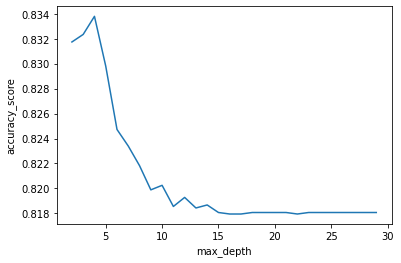

In [43]:
x = np.zeros(28)
y = np.zeros(28)
for i in tqdm(range(2,30)):
    my_clf = MyDecisionTreeClassifier(max_depth = i)
    x[i-2] = i
    y[i-2] = np.mean(cross_val_score(my_clf, samples, target,cv = 10, scoring='accuracy'))
plt.xlabel("max_depth")
plt.ylabel("accuracy_score")
plt.plot(x,y)
print('optimal depth', x[np.argmax(y)])
print('best accuracy', np.max(y))

100%|██████████| 98/98 [09:29<00:00,  5.81s/it]

optimal minimal samples 24.0
best accuracy 0.830048074811668


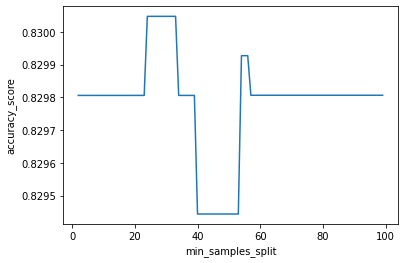

In [44]:
x = np.zeros(98)
y = np.zeros(98)
for i in tqdm(range(2,100)):
    my_clf = MyDecisionTreeClassifier(min_samples_split=i)
    x[i-2] = i
    y[i-2] = np.mean(cross_val_score(my_clf, samples, target,cv = 10, scoring='accuracy'))
plt.xlabel("min_samples_split")
plt.ylabel("accuracy_score")
plt.plot(x,y)
print('optimal minimal samples', x[np.argmax(y)])
print('best accuracy', np.max(y))

100%|██████████| 28/28 [12:27<00:00, 26.69s/it]

optimal depth 3.0
best accuracy 0.8351290144078044


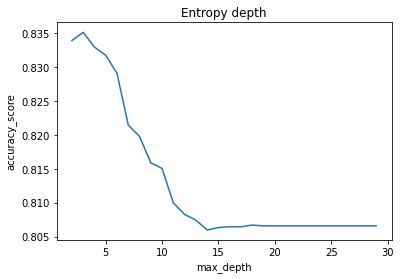

In [45]:
x = np.zeros(28)
y = np.zeros(28)
for i in tqdm(range(2,30)):
    my_clf = MyDecisionTreeClassifier(max_depth = i, criterion = 'entropy')
    x[i-2] = i
    y[i-2] = np.mean(cross_val_score(my_clf, samples, target,cv = 10, scoring='accuracy'))
plt.title('Entropy depth')
plt.xlabel("max_depth")
plt.ylabel("accuracy_score")
plt.plot(x,y)
print('optimal depth', x[np.argmax(y)])
print('best accuracy', np.max(y))

100%|██████████| 28/28 [01:03<00:00,  2.26s/it]

optimal depth 2.0
best accuracy 0.8353704132032991


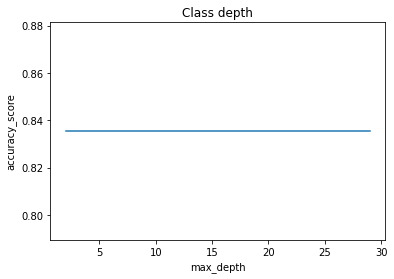

In [46]:
x = np.zeros(28)
y = np.zeros(28)
for i in tqdm(range(2,30)):
    my_clf = MyDecisionTreeClassifier(max_depth = i, criterion = 'class')
    x[i-2] = i
    y[i-2] = np.mean(cross_val_score(my_clf, samples, target,cv = 10, scoring='accuracy'))
plt.title('Class depth')
plt.xlabel("max_depth")
plt.ylabel("accuracy_score")
plt.plot(x,y)
print('optimal depth', x[np.argmax(y)])
print('best accuracy', np.max(y))

100%|██████████| 98/98 [14:40<00:00,  8.98s/it]

optimal minimal samples 54.0
best accuracy 0.8322253484838281


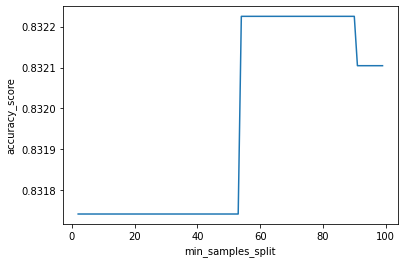

In [47]:
x = np.zeros(98)
y = np.zeros(98)
for i in tqdm(range(2,100)):
    my_clf = MyDecisionTreeClassifier(min_samples_split=i, criterion = 'entropy')
    x[i-2] = i
    y[i-2] = np.mean(cross_val_score(my_clf, samples, target,cv = 10, scoring='accuracy'))
plt.xlabel("min_samples_split")
plt.ylabel("accuracy_score")
plt.plot(x,y)
print('optimal minimal samples', x[np.argmax(y)])
print('best accuracy', np.max(y))

100%|██████████| 98/98 [03:37<00:00,  2.22s/it]

optimal minimal samples 2.0
best accuracy 0.8353704132032991


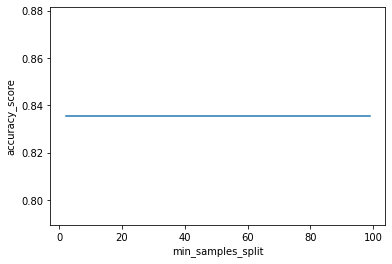

In [48]:
x = np.zeros(98)
y = np.zeros(98)
for i in tqdm(range(2,100)):
    my_clf = MyDecisionTreeClassifier(min_samples_split=i, criterion = 'class')
    x[i-2] = i
    y[i-2] = np.mean(cross_val_score(my_clf, samples, target,cv = 10, scoring='accuracy'))
plt.xlabel("min_samples_split")
plt.ylabel("accuracy_score")
plt.plot(x,y)
print('optimal minimal samples', x[np.argmax(y)])
print('best accuracy', np.max(y))

100%|██████████| 10/10 [00:44<00:00,  4.42s/it]

optimal minimal samples 20.0
best accuracy 0.8337977344525415


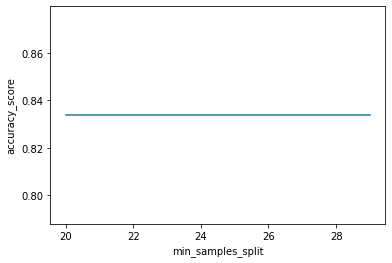

In [54]:
x = np.zeros(10)
y = np.zeros(10)
for i in tqdm(range(20,30)):
    my_clf = MyDecisionTreeClassifier(max_depth = 4, min_samples_split = i)
    x[i-20] = i
    y[i-20] = np.mean(cross_val_score(my_clf, samples, target,cv = 10, scoring='accuracy'))
plt.xlabel("min_samples_split")
plt.ylabel("accuracy_score")
plt.plot(x,y)
print('optimal minimal samples', x[np.argmax(y)])
print('best accuracy', np.max(y))

Максимальная точность - 83.537 процентов

## Находим самые важные признаки (2 балла)



По построенному дереву  легко понять, какие признаки лучше всего помогли решить задачу. Часто это бывает нужно  не только  для сокращения размерности в данных, но и для лучшего понимания прикладной задачи. Например, Вы хотите понять, какие признаки стоит еще конструировать -- для этого нужно понимать, какие из текущих лучше всего работают в дереве. 

Самый простой метод -- посчитать число сплитов, где использовался данные признак. Это не лучший вариант, так как по признаку который принимает всего 2 значения, но который почти точно разделяет выборку, число сплитов будет очень 1, но при этом признак сам очень хороший. 
В этом задании предлагается для каждого признака считать суммарный gain (в лекции обозначено как Q) при использовании этого признака в сплите. Тогда даже у очень хороших признаков с маленьким число сплитов это значение должно быть довольно высоким.  

Реализовать это довольно просто: создаете словарь номер фичи : суммарный гейн и добавляете в нужную фичу каждый раз, когда используете ее при построении дерева. 

Добавьте функционал, который определяет значения feature importance. Обучите дерево на датасете Speed Dating Data.
Выведите 10 главных фичей по важности.

In [59]:
my_clf = MyDecisionTreeClassifier(min_samples_split=2)
my_clf.fit(samples, target)
f = my_clf.get_feature_importance()
feat = sorted(f,key=lambda i: f[i])[-10:]
for i in range(samples.shape[1]):
    if i in feat:
        print(df.drop(['match', 'dec'], axis = 1).columns[i])

gender
imprace
imprelig
attr3_1
attr
intel
like
prob
satis_2
shar1_2


In [60]:
my_clf = MyDecisionTreeClassifier(criterion = 'class')
my_clf.fit(samples, target)
f = my_clf.get_feature_importance()
feat = sorted(f,key=lambda i: f[i])[-10:]
for i in range(samples.shape[1]):
    if i in feat:
        print(df.drop(['match', 'dec'], axis = 1).columns[i])

prob
intel1_2
fun1_2
amb1_2
shar1_2
attr3_2
sinc3_2
intel3_2
fun3_2
amb3_2


In [61]:
my_clf = MyDecisionTreeClassifier(criterion = 'entropy')
my_clf.fit(samples, target)
f = my_clf.get_feature_importance()
feat = sorted(f,key=lambda i: f[i])[-10:]
for i in range(samples.shape[1]):
    if i in feat:
        print(df.drop(['match', 'dec'], axis = 1).columns[i])

gender
samerace
imprace
date
exphappy
attr3_1
like
prob
satis_2
shar1_2


## Фидбек (бесценно)

* Какие аспекты обучения деревьев решений Вам показались непонятными? Какое место стоит дополнительно объяснить?

### Ваш ответ здесь

* Здесь Вы можете оставить отзыв о этой домашней работе или о всем курсе.

### ВАШ ОТЗЫВ ЗДЕСЬ

